European Centre for Disease Prevention and Control (na swojej stronie www organizacja ta informuje, że jest oficjalną agencją Unii Europejskiej) publikuje dane dotyczące COVID-19 dla krajów Europejskiego Obszaru gospodarczego. Pobrałem stamtąd dane o zachorowaniach: https://www.ecdc.europa.eu/en/publications-data/data-daily-new-cases-covid-19-eueea-country oraz dane o szczepieniach: https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea i wyliczyłem dla nich szereg statystyk. 

In [187]:
import numpy as np
import pandas as pd
from datetime import date
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

COUNTRY_VAC_THRESHOLD_DATE = {}
HIGH_VAC_COUNTRIES = np.array(['Niemcy','Dania','Finlandia','Francja','Włochy','Malta','Norwegia'])
LOW_VAC_COUNTRIES = np.array(['Bułgaria','Chorwacja','Czechy','Estonia','Holandia','Islandia','Litwa','Luxemburg','Polska','Rumunia','Słowacja','Słowenia','Węgry','Łotwa'])
    

def translate_country(country):
    if country == 'Belgium':
        return 'Belgia'
    elif country == 'Bulgaria':
        return 'Bułgaria'
    elif country == 'Cyprus':
        return 'Cypr'
    elif country == 'Czechia':
        return 'Czechy'
    elif country == 'Germany':
        return 'Niemcy'
    elif country == 'Denmark':
        return 'Dania'
    elif country == 'Greece':
        return 'Grecja'
    elif country == 'Spain':
        return 'Hiszpania'
    elif country == 'Finland':
        return 'Finlandia'
    elif country == 'France':
        return 'Francja'
    elif country == 'Croatia':
        return 'Chorwacja'
    elif country == 'Ireland':
        return 'Irlandia'
    elif country == 'Hungary':
        return 'Węgry'
    elif country == 'Iceland':
        return 'Islandia'
    elif country == 'Italy':
        return 'Włochy'
    elif country == 'Lithuania':
        return 'Litwa'
    elif country == 'Luxembourg':
        return 'Luxemburg'
    elif country == 'Latvia':
        return 'Łotwa'
    elif country == 'Netherlands':
        return 'Holandia'
    elif country == 'Norway':
        return 'Norwegia'
    elif country == 'Poland':
        return 'Polska'
    elif country == 'Portugal':
        return 'Portugalia'
    elif country == 'Romania':
        return 'Rumunia'
    elif country == 'Slovenia':
        return 'Słowenia'
    elif country == 'Slovakia':
        return 'Słowacja'
    elif country == 'Sweden':
        return 'Szwecja'
    return country



def hide_unused_subplots(used, size, fig):
    """
    Removes unused subplots from the given matplot figure.
    
    Parameters:
    used - index of the last used sublot
    size - number of subplots in the figure
    """
    for i in range(len(countries), 32):
        fig.axes[i].set_axis_off()
        


def find_threshold_for(df_v, country):
    """
    Searches when second dose vaccinations reaches threshold given as country population percent.
    The result is saved in global variable COUNTRY_VAC_THRESHOLD_DATE
    
    Parameters:
    df_v - data frame with Second, country, week and year columns, must by sorted by date
    country - country name
    """
    threshold = 70
    df_country_above_tr = df_v[(df_v.country == country) & (df_v.Second >= threshold)]
    if df_country_above_tr.shape[0] > 0:
        threshold_row = df_country_above_tr.iloc[0]
        COUNTRY_VAC_THRESHOLD_DATE[country] = {'week':threshold_row.week, 'year':threshold_row.year}


def find_threshold_index_for(df, country):
    """
    Looks for threshold date in COUNTRY_VAC_THRESHOLD_DATE for given country. Raises exception when data for country not present.
    """
    date = COUNTRY_VAC_THRESHOLD_DATE[country]
    return df[(df.country==country) & (df.week==date.get('week')) & (df.year==date.get('year'))].index.values[0]


def plot_threshold_line(df, country, ax, label_y):
    """
    Plots vertical line on matplot chart in place dictated by the content of COUNTRY_VAC_THRESHOLD_DATE
    """
    try:
        i = find_threshold_index_for(df, country)
        col = '0.5'
        ax.axvline(i, ls='--', color=col)
        ax.text(i,label_y,f'{tr}% populacji\nprzyjęło drugą\ndawkę', rotation=45, color=col)
    except:
        #print(f"{country} didn't reach threshold")
        pass


In [2]:
def load_weekly_cases():
    df = pd.read_csv('cases.csv')
    df['week'] = df.apply(lambda x: date(x.year,x.month,x.day).isocalendar()[1], axis=1)
    df['country'] = df.apply(lambda x: translate_country(x.countriesAndTerritories), axis=1)
    #cutoff at the 31st week of 2022 (some countries has more data)
    df = df[(df.year < 2022) | (df.week < 32)]
    #group by week
    df = df.groupby([df.country, df.geoId, df.countriesAndTerritories, df.year, df.week]).agg({
        'cases':'sum', 
        'deaths':'sum', 
        'popData2020':'median'
    })
    #moving multiindex to columns
    return df.reset_index()
    

In [160]:
def load_weekly_vaccinations():
    df = pd.read_csv('vaccination.csv')

    #There are different TargetGroup's, but ALL carries the sum
    df = df.query('TargetGroup == "ALL"')

    #Some countries reports data per region, but there always should be also a region covering whole country
    # so we need to filter out the "small" regions
    df = df.query('ReportingCountry == Region')

    df = df.assign(
        year = df['YearWeekISO'].str.split("-").str.get(0).astype("int64"),
        week = df['YearWeekISO'].str.split("-").str.get(1).str.split('W').str.get(1).astype("int64")
    )

    # Calculate FirstDose and SecondDose as a sum over all vaccination types
    df = df.groupby(['ReportingCountry','year','week']).agg({
        'FirstDose' : 'sum',
        'SecondDose' : 'sum',
        'Population' : 'median'
    })
    # TotalXxxDose as cumulative sum from first vaccination till the current (row) year and week
    df['TotalFirstDose'] = df.groupby('ReportingCountry')['FirstDose'].transform(pd.Series.cumsum)
    df['TotalSecondDose'] = df.groupby('ReportingCountry')['SecondDose'].transform(pd.Series.cumsum)

    # First and Second as a percentage of total vacinations against the whole Population
    df = df.assign(
        First = 100 * df.TotalFirstDose / df.Population,
        Second = 100 * df.TotalSecondDose / df.Population
    )
    # Moving the MultiIndex (ReportingCountry, year week) to columns 
    df = df.reset_index()
    # Adding country column
    df_c = load_weekly_cases()
    countries = dict(zip(df_c.geoId, df_c.countriesAndTerritories))
    df['country'] = df.apply(lambda x: translate_country(countries[x.ReportingCountry]), axis=1)
    return df

# Postęp programu szczepień

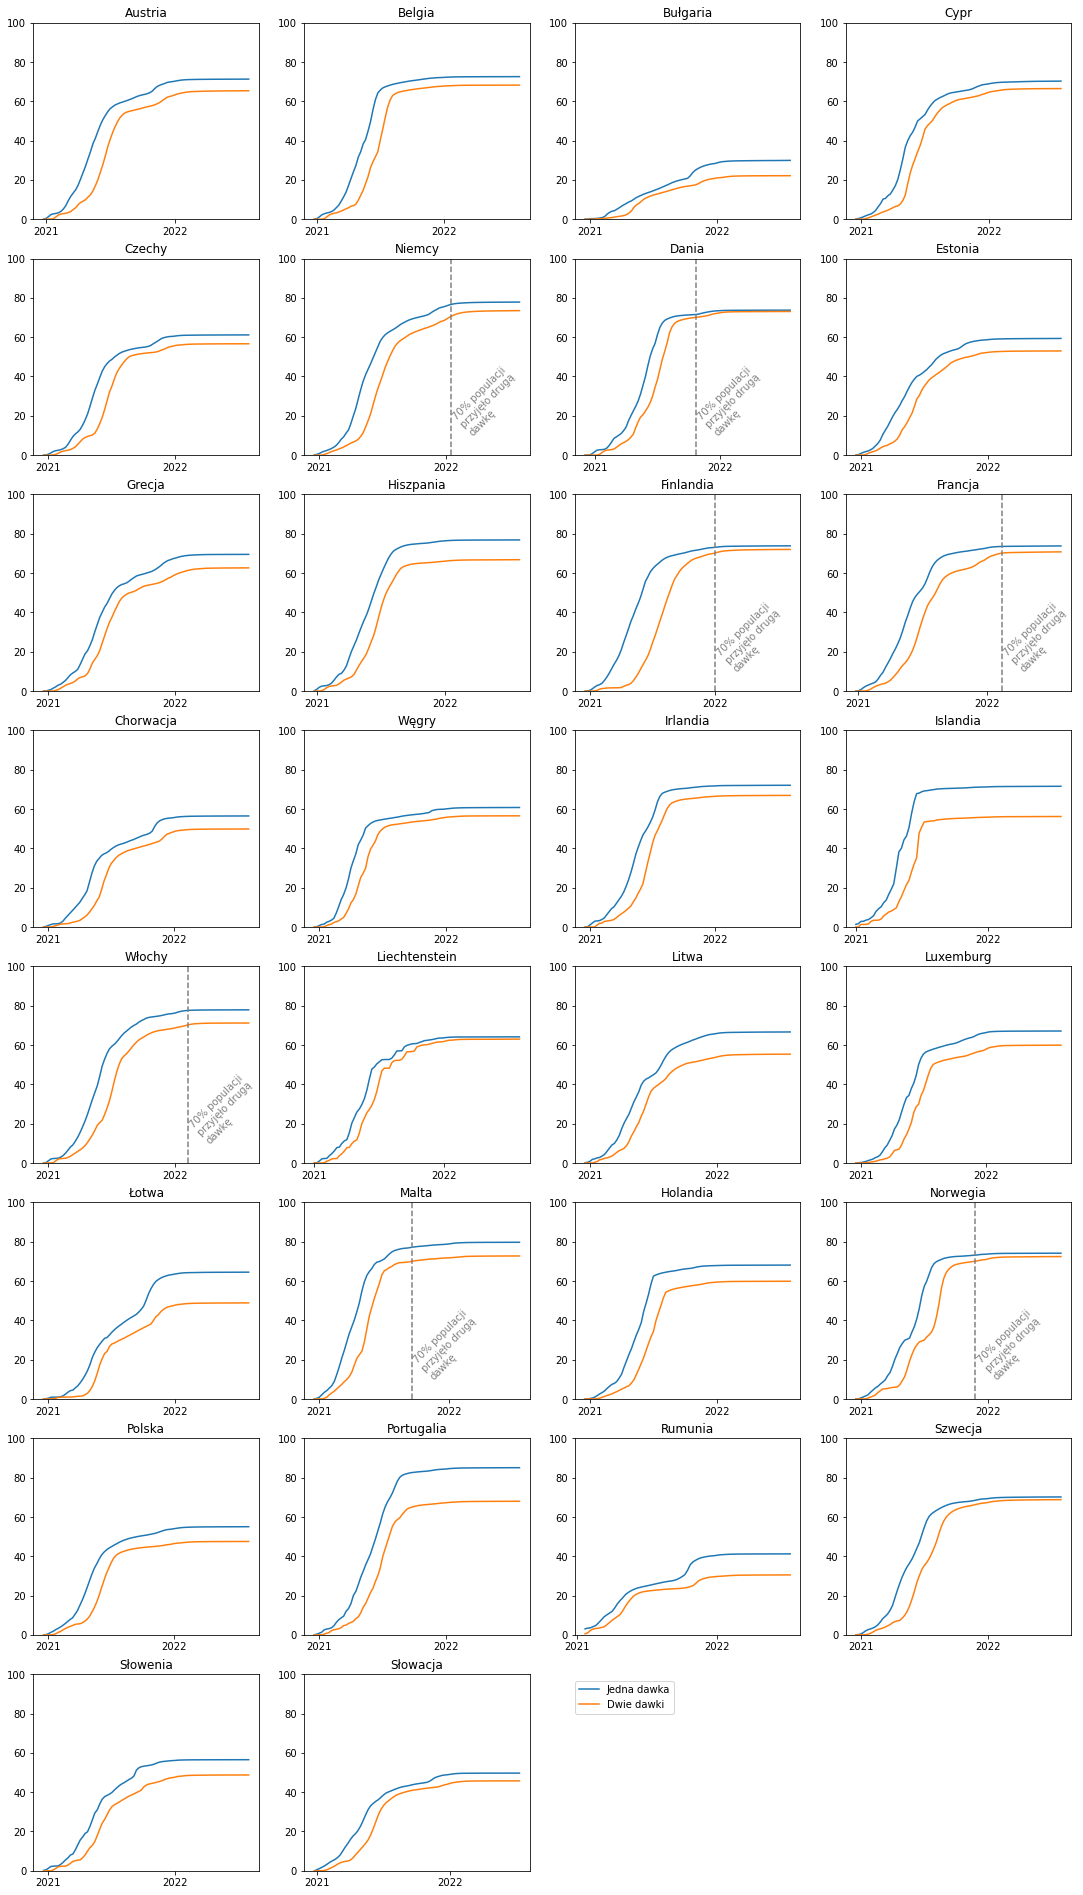

In [182]:
def plot_vaccination_progress():
    df_v = load_weekly_vaccinations()
    countries = df_v.country.unique()
    fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(18.6, 34))

    hide_unused_subplots(len(countries), 32, fig)

    for i,country in enumerate(countries, start=0):
        c = df_v[df_v.country == country]

        # shift is neccesary to not fail on coutries (Lichtenstein) with missing reading on week 1
        shift = 3
        ticks = c.index[(c.year > 2020) & (c.week == 1+shift)].tolist()
        ticks = [ t-shift for t in ticks ]

        c.First.plot(kind='line', ax=fig.axes[i])
        c.Second.plot(kind='line', ax=fig.axes[i])
        fig.axes[i].set_title(country)
        fig.axes[i].set_ylim([0,100])
        fig.axes[i].set_xticks(ticks)
        fig.axes[i].set_xticklabels(['2021','2022'])

        find_threshold_for(df_v, country)
        plot_threshold_line(df_v, country, fig.axes[i], 10)

    fig.axes[len(countries)-1].legend(['Jedna dawka', 'Dwie dawki'], loc=(1.2,0.8))

    
plot_vaccination_progress()

Wykresy pokazują jaki procent populacji kraju zaszczepiony został jedną dawką (niebieska linia), a jaki dwiema dawkami (pomarańczowa linia). Niestety do wyrysowania analogicznej krzywej dla trzech dawek zabrakło danych. Na niektórych wykresach jest dodatkowo pionowa linia wskazująca moment w którym odsetek zaszczepionych dwiema dawkami przekroczył 70%. Ma to być przybliżenie odporności populacyjnej. Aktualnie jest ona deklorowana na zdecydowanie wyższym poziomie, dochodzącym nawet do 95%, ale takich poziomów zaszcepienia nie osiągnięto. Aby więc mieć co porównywać przyjąłem wartość deklarowaną w przeszłości, gdy COVID uważano za mnie zaraźliwy. Według https://piaseczno.eu/szczepimysie-osiagnijmy-razem-zbiorowa-odpornosc/ było to 67% (źródło takie sobie, ale sama wartość progu nie jest krytyczna dla analizy). Znajdujące sie dalej statystyki i tak zmierzają tylko w stronę ustalenia istnienia i zbadania siły relacji pomiędzy stopniem zaszczepienia a zachorowaniami i śmiertelnością. Osiągnięcie poziomu odporności populacyjnej powinno jedynie sprawić że relacja będzie wyraźniejsza.

# Postęp zachorowań i zgonów spowodowanych COVID

Na poniższch wykresach widać jak w poszczególnych krajach wyglądała liczba zachorowań i zgonów w ujęciu tygodniowym. Zarówno zachorowania jak i zgony są przedstawione jako procent populacji kraju, którego dotyczą, dzięki czemu można porównywać dane opisujące kraje o różnym rozmiarze. Liczba zgonów jest oczywiście o wiele mniejsza niż liczba zachorowań. Żeby więc dało się dostrzec zmienność obu wielkości są one zaprezentowane na dwóch różnych skalach. Po lewej stronie wykresu jest zawsze skala dla zachorowań, a po prawej dla zgonów. Natomiast na skale nie zmieniają się pomiędzy poszczególnymi wykresami, czyli jeżeli dla jednego kraju linia jest wyżej niż dla drugiego, to znaczy to po prostu, że było więcej.

Linie dla zachorowań i dla zgonów leżą blisko siebie (mamy podobną zmienność przy uwzględnieniu różnicy skali) do mniej więcej końca 2021. Natomiast od 2022 niektórych krajów liczba zachorowań zaczyna mocno uciekać w górę (np. Austria, Dania, Irlandia), kiedy dla innych utrzymuje się podobna relacja jak dla lat 2020 i 2021 (np. Bułgaria, Chorwacja, Hiszpania). Może być to efekt szczepienia ale jeżeli zwrócimy uwagę na to dla których krajów został osiągnięty próg zaszczepienia drugą dawką 70% społeczeństwa oraz kiedy to nastąpiło to związek śmiertelności z poziomem zaszczepienia społeczeńśtwa przestaje być oczywisty. Pewnym problemem interpretacji może być czytelność intensywnie fluktuujących z tygodnia na tydzień liczb zachorowań i zgonów. Może więc spróbujmy to zilustrować skumulowaną liczbą zacorowań i zgonów.

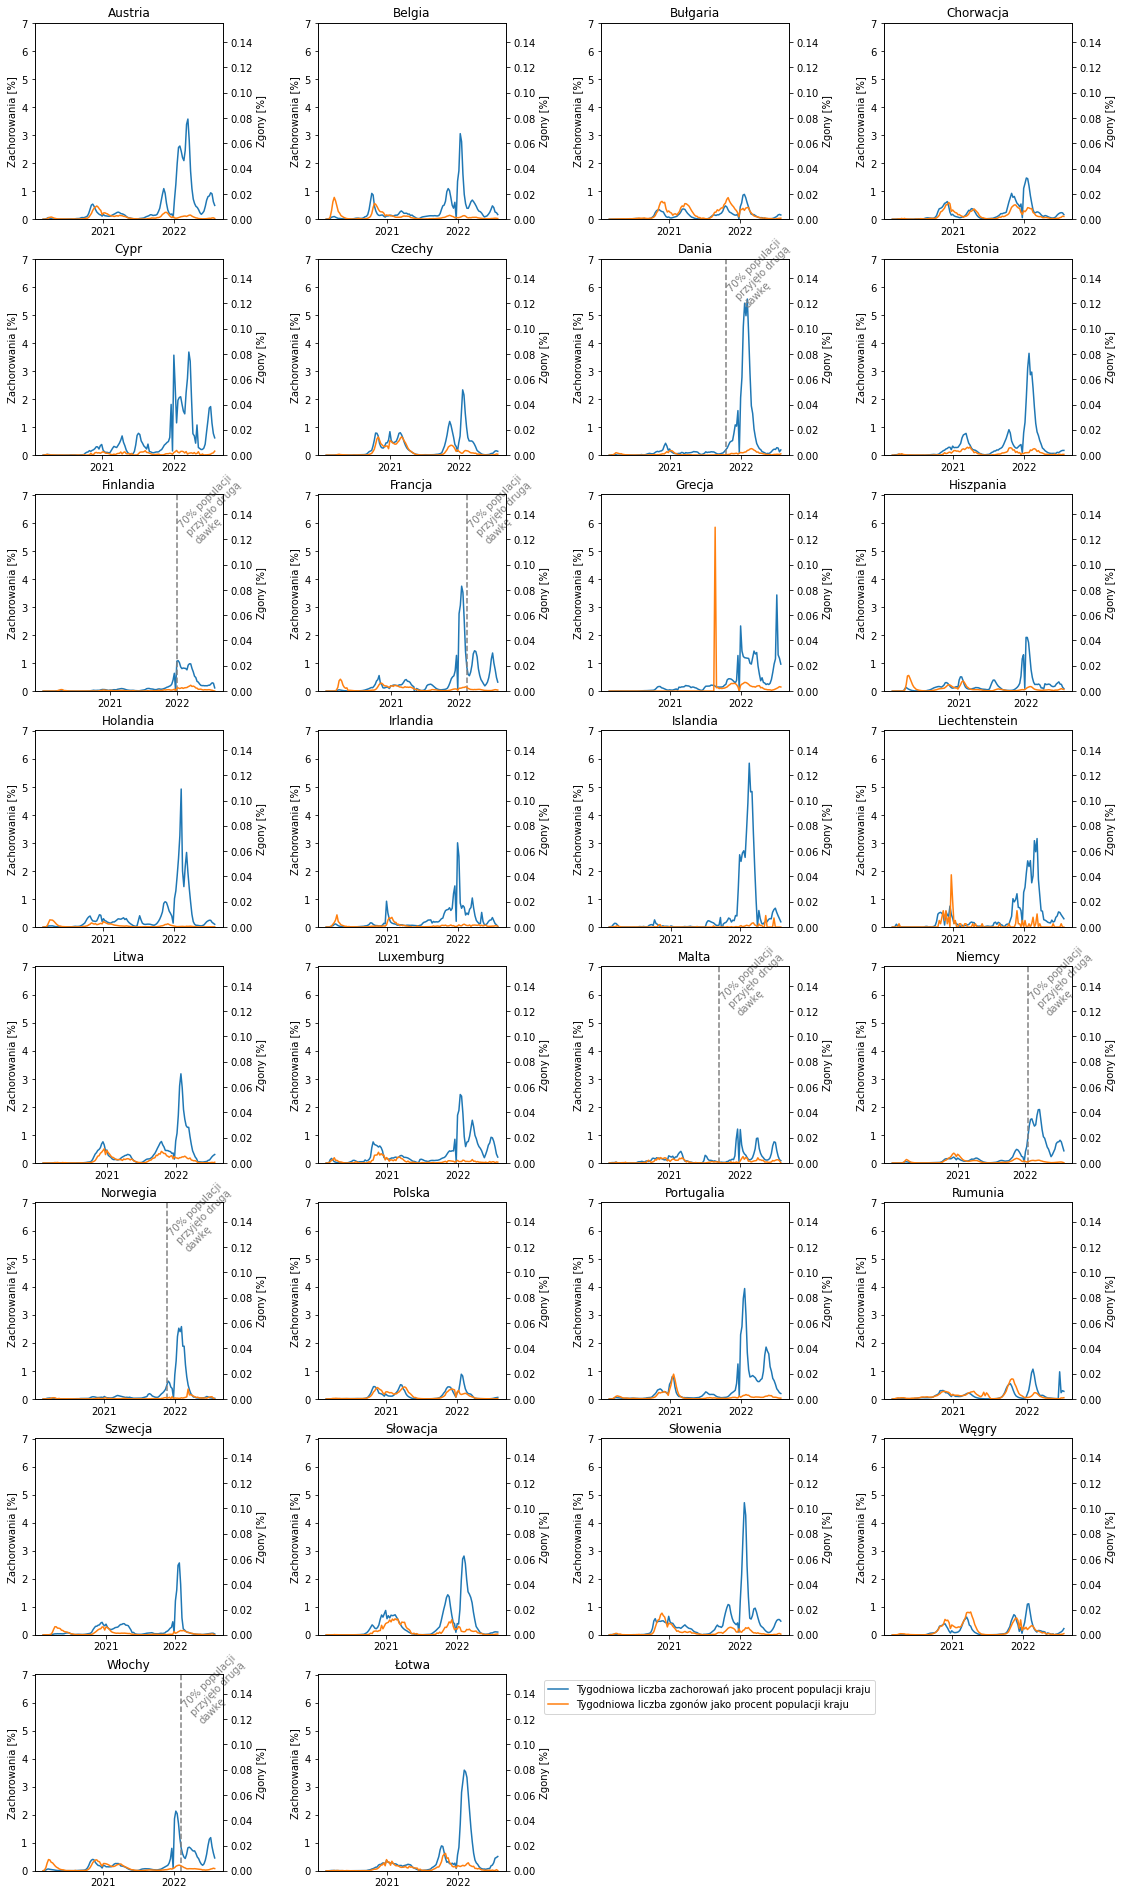

In [183]:
def plot_two_vars_per_country(first,second,df,legend_first,legend_second):

    countries = df_c.country.unique()
    fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(18.6, 34))

    hide_unused_subplots(len(countries), 32, fig)
    max_y1 = df[first].max() * 1.2
    max_y2 = df[second].max() * 1.2

    for i,country in enumerate(countries, start=0):
        c = df[df.country == country]
        ticks = c.index[(c.year > 2020) & (c.week == 1)].tolist()

        c[first].plot(kind='line', ax=fig.axes[i])
        c[second].plot(kind='line', ax=fig.axes[i], secondary_y=True)
        fig.axes[i].set_title(country)
        fig.axes[i].set_ylim([0,max_y1])
        fig.axes[i].right_ax.set_ylim(0,max_y2)
        fig.axes[i].set_xticks(ticks)
        fig.axes[i].set_xticklabels(['2021','2022'])
        fig.axes[i].set_ylabel('Zachorowania [%]')
        fig.axes[i].right_ax.set_ylabel('Zgony [%]')
        plot_threshold_line(df, country, fig.axes[i], max_y1*0.75)

    ax = fig.axes[len(countries)-1]
    ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]], [legend_first, legend_second], loc=(1.2,0.8))
    fig.subplots_adjust(wspace=0.5)
   


df_c = load_weekly_cases()
df_c['CasesPrc'] = df_c.cases * 100 / df_c.popData2020
df_c['DeathsPrc'] = df_c.deaths * 100 / df_c.popData2020

plot_two_vars_per_country('CasesPrc','DeathsPrc',df_c,
                          'Tygodniowa liczba zachorowań jako procent populacji kraju',
                          'Tygodniowa liczba zgonów jako procent populacji kraju') 

Widoczne poniżej wykresy przedstawiają zależność skumulowanej liczby zachorowań oraz skumulowanej liczby zgonów liczonej od początku pandemii, a przedstawionej jako procent populacji. Sposób prezentacji jest analogiczny do tego z poprzedniej ilustracji, a w szczególności ponownie po lewej stronie wykresu jest skala dla zachorowań, a po prawej dla zgonów.

To ujęcie tych samych danych co wcześniej wydaje się bardziej czytelne. Dla kilku krajów, np. Dania, Francja, mamy wykresy, które można tłumaczyć pozytywnym efektem szczepień - co prawda nie zmniejszyły liczby zachorowań, ale za to sprawiły że zdecydowanie mniejszy ich odesetek kończy się zgonem. Niestety są też kraje nieco zaburzające tą jakże optymistyczną wizję (np. Malta, Włochy), a mymy również kraje w których jakby szczepionki zadziałały podobnie jak dla Danii czy Francji pomimo tego, że nie uzyskano wysokiego poziomu wyszczepienia.

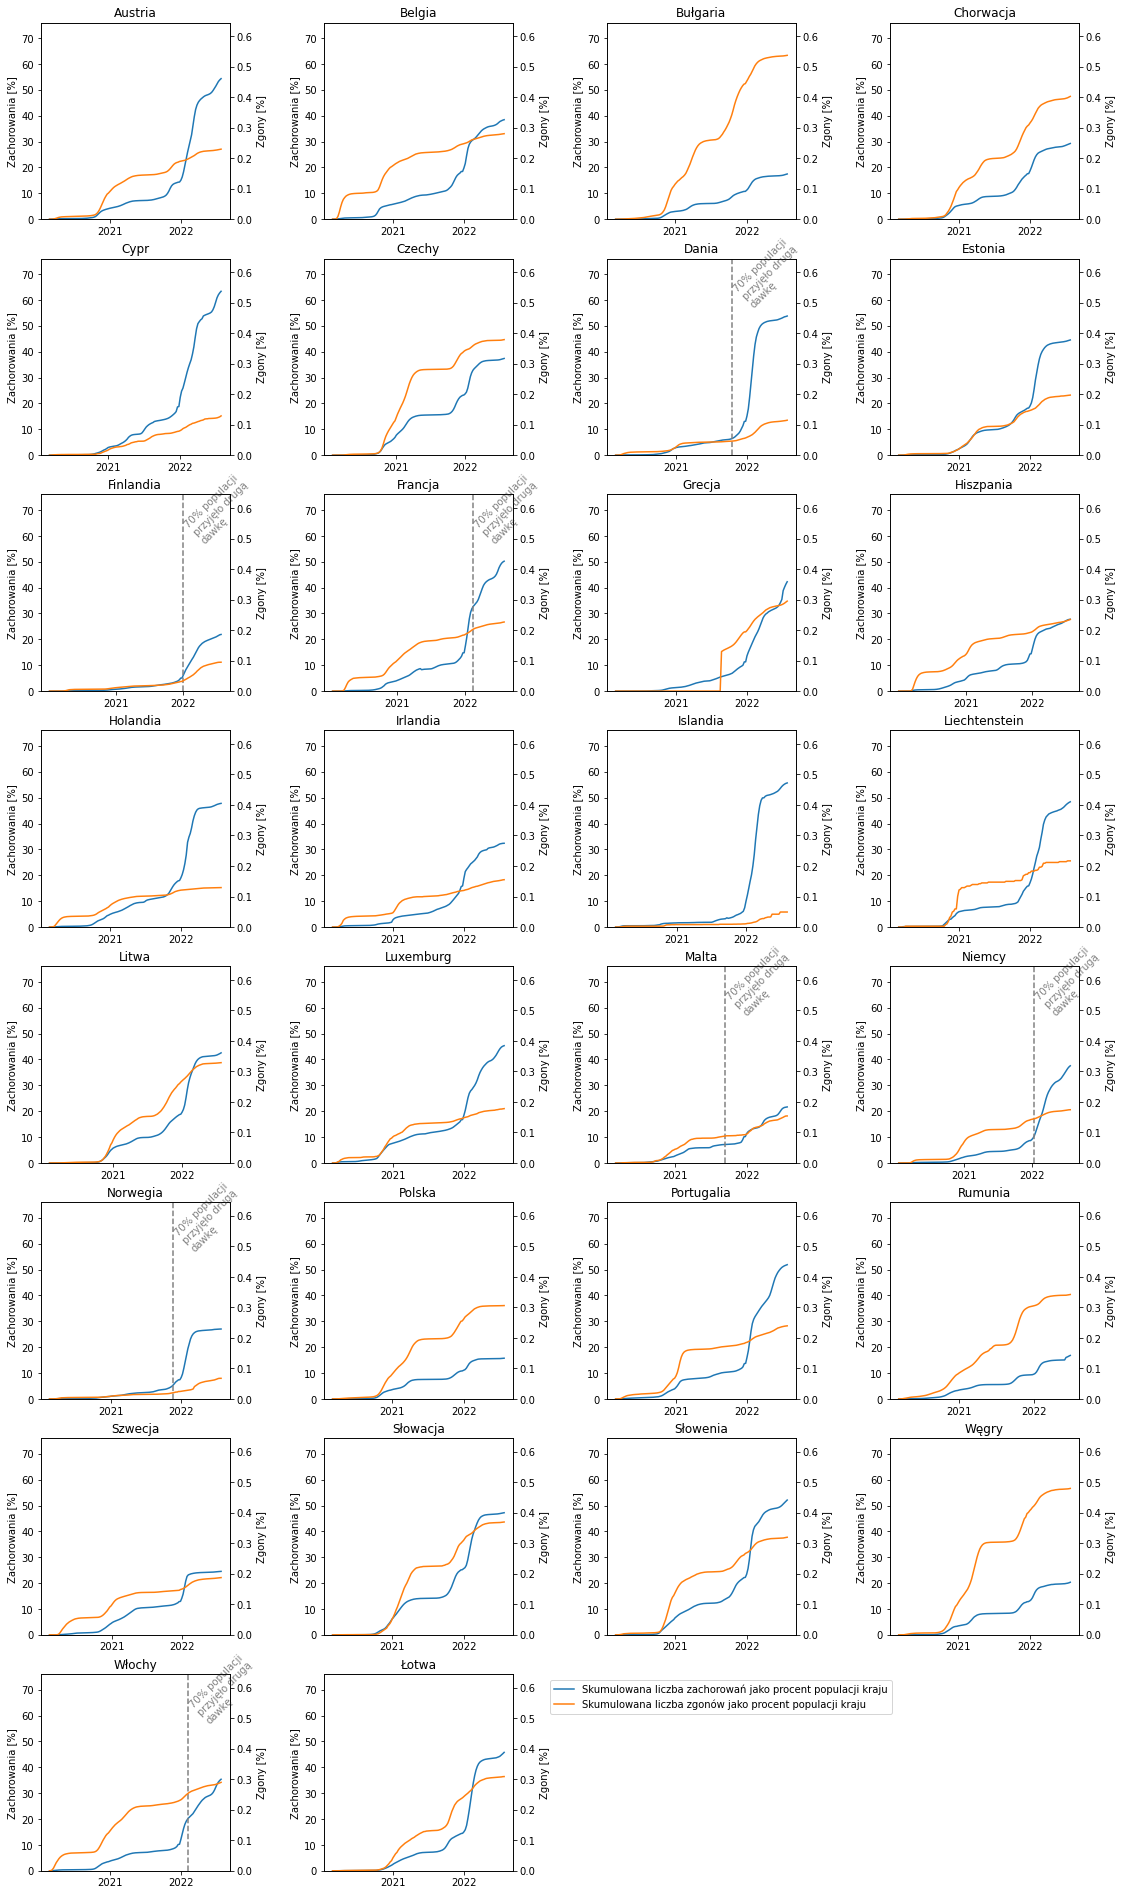

In [184]:
df_c = load_weekly_cases()
df_c['CumulativeCasesPrc'] = df_c.groupby('country')['cases'].transform(pd.Series.cumsum) * 100 / df_c.popData2020
df_c['CumulativeDeathsPrc'] = df_c.groupby('country')['deaths'].transform(pd.Series.cumsum) * 100 / df_c.popData2020

plot_two_vars_per_country('CumulativeCasesPrc',
                          'CumulativeDeathsPrc',
                          df_c,
                          'Skumulowana liczba zachorowań jako procent populacji kraju',
                          'Skumulowana liczba zgonów jako procent populacji kraju'
                          ) 

# Analiza porównawcza grupy krajów z wysokim i z niskim poziomem zaszczepienia

Spróbujmy uchwyćić efekt szczepienia przy pomocy analizy porównawczej. Podzielmy więc kraje na dwie grupy. W pierwszej będą te o wysokim poziomie zaszczepienia, czyli takie które przekroczyły 70% populacji zaszczepionej dwoma dawkami na koniec badanego okresu:

|Kraj     |  Odsetek populacji |
|---------|--------------------|
|Dania    |  73.053136 |
|Finlandia|  72.033667 |
|Francja  |  70.804443 |
|Malta    |  72.700446 |
|Niemcy   |  73.486148 |
|Norwegia |  72.392949 |
|Włochy   |  71.177239 |

W drugiej grupie będą kraje o niskim poziomie zaszczepienia, to jest mniejszym niż 60% populacji:

|Kraj      | Odsetek populacji|
|----------|------------------|
|Bułgaria  | 22.122264|
|Chorwacja | 49.851165|
|Czechy    | 56.640360|
|Estonia   | 52.993682|
|Holandia  | 59.842218|
|Islandia  | 56.202683|
|Litwa     | 55.334874|
|Luxemburg | 59.907835|
|Polska    | 47.500744|
|Rumunia   | 30.491366|
|Słowacja  | 45.740424|
|Słowenia  | 48.743443|
|Węgry     | 56.547692|
|Łotwa     | 48.829905|

Grupy zostały zdefiniowane tak aby różnica pomiędzy nimi była istotna, w efekcie kraje o poziomie zaszczepienia w przedziale od 60% do 70% nie są uwzględnione w tej analizie.

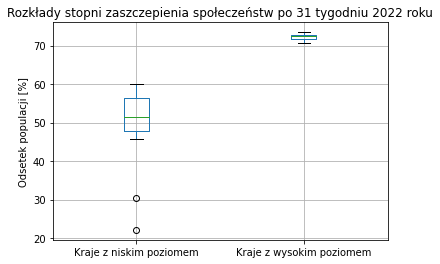

In [190]:
def plot_vaccination_level_comparison(df):
    h = df[df.country.isin(HIGH_VAC_COUNTRIES)]
    h = h.groupby(h.country).agg({'Second':'max'})

    l = df[(df.year == 2022) & df.country.isin(LOW_VAC_COUNTRIES)]
    l = l.groupby(l.country).agg({'Second':'max'})
    h['Poziom zaszczepienia'] = h.apply(lambda x: 'wysoki', axis=1)
    l['Poziom zaszczepienia'] = l.apply(lambda x: 'niski', axis=1)
    a = h.append(l)
    ax = a.groupby('Poziom zaszczepienia').boxplot(subplots=False)
    ax.set_xticks(ticks=[1,2])
    ax.set_xticklabels(['Kraje z niskim poziomem','Kraje z wysokim poziomem'])
    ax.set_title('Rozkłady stopni zaszczepienia społeczeństw po 31 tygodniu 2022 roku')
    ax.set_ylabel('Odsetek populacji [%]')
    
    
plot_vaccination_level_comparison(load_weekly_vaccinations())    


In [83]:
# df_c = load_weekly_cases()
# df_v = load_weekly_vaccinations()
# #merged = shifted_df_c.merge(df_v, left_on=['country','year','week'], right_on=['country','year','week'])
# df = df_c.merge(df_v, left_on=['country','year','week'], right_on=['country','year','week'])
# df.head()

<ipython-input-3-e05da2e26d88>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['year'] = df_v['YearWeekISO'].str.split("-").str.get(0).astype("int64")
<ipython-input-3-e05da2e26d88>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['week'] = df_v['YearWeekISO'].str.split("-").str.get(1).str.split('W').str.get(1).astype("int64")


,country,geoId,countriesAndTerritories,year,week,cases,deaths,popData2020,ReportingCountry,FirstDose,SecondDose,Population,TotalFirstDose,TotalSecondDose,First,Second
0,Austria,AT,Austria,2020,53,9814.0,323.0,8901064,AT,5333,0,8901064,5333,0,0.059914,0.000000
1,Austria,AT,Austria,2021,1,14573.0,437.0,8901064,AT,26375,0,8932664,31708,0,0.354967,0.000000
2,Austria,AT,Austria,2021,2,10947.0,451.0,8901064,AT,85330,401,8932664,117038,401,1.310225,0.004489
3,Austria,AT,Austria,2021,3,10481.0,402.0,8901064,AT,93659,4645,8932664,210697,5046,2.358725,0.056489
4,Austria,AT,Austria,2021,4,9624.0,370.0,8901064,AT,31766,17544,8932664,242463,22590,2.714341,0.252892


        cases_prc            deaths_prc          
             mean     median       mean    median
poziom                                           
niski   20.874026  22.873682   0.055318  0.052608
wysoki  25.434220  25.125716   0.051455  0.058048


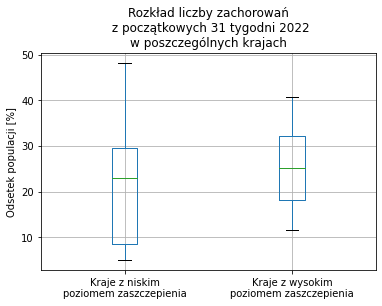

In [231]:
def to_country_level_data_frame(df):
    #Only cases and deaths from 2022 (till 32nd week), earlier vaccination level was lower
    by_country = df[df.year >= 2022].groupby(df.country).agg({
        'cases':['sum','max'], 
        'deaths':['sum','max'], 
        'popData2020':'median'
    })
    by_country.columns = by_country.columns.to_flat_index().str.join('_')
    #Which percent of the population is the number of cases and deaths
    by_country = by_country.assign(
        cases_prc = 100 * by_country.cases_sum / by_country.popData2020_median,
        deaths_prc = 100 * by_country.deaths_sum / by_country.popData2020_median,
        max_cases_prc = 100 * by_country.cases_max / by_country.popData2020_median,
        max_deaths_prc = 100 * by_country.deaths_max / by_country.popData2020_median
    )
    by_country = by_country.reset_index()
    h = by_country[by_country.country.isin(HIGH_VAC_COUNTRIES)]
    l = by_country[by_country.country.isin(LOW_VAC_COUNTRIES)]
    return h.assign(poziom = 'wysoki').append(l.assign(poziom = 'niski'))


def boxplot_group_by_level(df, variable, desc):
    ax = df[[variable,'poziom']].groupby('poziom').boxplot(subplots=False)
    ax.set_xticks(ticks=[1,2])
    ax.set_xticklabels(['Kraje z niskim\npoziomem zaszczepienia','Kraje z wysokim\npoziomem zaszczepienia'])
    ax.set_title(f'{desc}\n z początkowych 31 tygodni 2022\nw poszczególnych krajach')
    ax.set_ylabel('Odsetek populacji [%]')

    
a = to_country_level_data_frame(load_weekly_cases())

print(a.groupby(a.poziom).agg({
    'cases_prc':['mean','median'],
    'deaths_prc':['mean','median']
}))

boxplot_group_by_level(a, 'cases_prc', 'Rozkład liczby zachorowań')


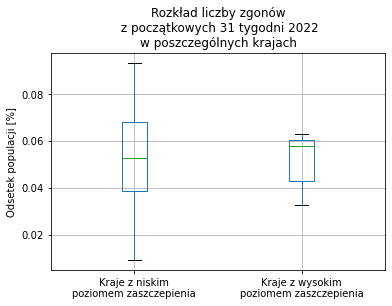

In [232]:
a = to_country_level_data_frame(load_weekly_cases())
boxplot_group_by_level(a, 'deaths_prc', 'Rozkład liczby zgonów')


Statystyki zachorowań i zgonów dotyczą tylko 2022 roku, czyli okresu kiedy już poziom wyszczepienia się ustabilizował. Dane kończą się na 31 tygodniu, więc oczywiście nie jest to cały rok.

Same statystyki dotyczą odsetka populacji w poszczególnych krajach (liczba przypadków podzielonej przez liczebność populacji) jaki w badanym okresie odpowiednio zachorował albo zmarł. W przedstawionych statystykach nie widać istotnej różnicy pomiędzy grupą krajów z wysokim poziomem wyszczepienia a grupą krajów z niskim poziomem. Minimalnie niższe wartości otrzymaliśmy dla krajów z niższym poziomem wyszczepienia, ale różnica jest na tyle mała w porównaniu ze zmiennością wewnątrz próby, że nawet nie ma sensu zastanawianie się nad jej istotnością. Innymi słowy przedstawione statystyki nie wskazują na istnienie zależności pomiędzy poziomem wyszczepienia a liczbą zachorowań albo zgonów.

W toku zmagań z pandemią często pojawiał się pogląd, że największym zagrożeniem jest szczyt pandemii, bo może od doprowadzić do załamania systemu opieki zdrowotnej. Przyjrzyjmy się więc analogicznym statystykom dla wartości maksymalnych. Czyli w miejsce skumulowanej liczby przypadków z początkowych 31 tygodniu roku 2022, analizowane będą liczby przypadków z tego tygodnia spośród tych 31, w którym przypadków było najwięcej.

       max_cases_prc          max_deaths_prc          
                mean   median           mean    median
poziom                                                
niski       2.777457  2.62740       0.005908  0.006082
wysoki      2.601170  2.12935       0.004661  0.004597


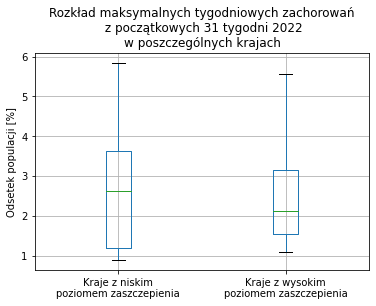

In [233]:
a = to_country_level_data_frame(load_weekly_cases())

print(a.groupby(a.poziom).agg({
    'max_cases_prc':['mean','median'],
    'max_deaths_prc':['mean','median']
}))

boxplot_group_by_level(a, 'max_cases_prc', 'Rozkład maksymalnych tygodniowych zachorowań')

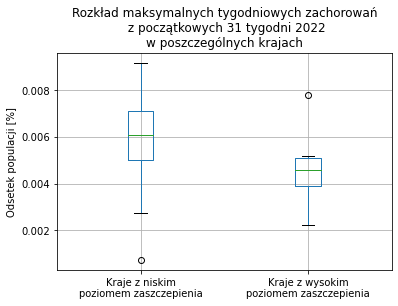

In [235]:
a = to_country_level_data_frame(load_weekly_cases())

boxplot_group_by_level(a, 'max_deaths_prc', 'Rozkład maksymalnych tygodniowych zachorowań')

Najgorszy tydzień zarówno pod względem liczby nowych przypadków jak i pod względem liczby zgonów był zauważalnie gorszy w krajach z niższym poziomem wyszczepienia społeczeństwa. Sprawdźmy więc (przy pomocu testu t (https://pl.wikipedia.org/wiki/Rozk%C5%82ad_Studenta#Zastosowania)) czy różnica ta jest istotna statystyczna

//i jaka jest wielkość zaobserwowanego efektu (https://pl.wikipedia.org/wiki/Wielko%C5%9B%C4%87_efektu).

In [11]:
print(f"t-test odnośnie maksymalnej liczby zachorować: {ttest_ind(h['cases_prc'], l['cases_prc'])}")
print(f"t-test odnośnie maksymalnej liczby zgonów: {ttest_ind(h['deaths_prc'], l['deaths_prc'])}")

t-test odnośnie maksymalnej liczby zachorować: Ttest_indResult(statistic=-0.23626602460606455, pvalue=0.8157545665214521)
t-test odnośnie maksymalnej liczby zgonów: Ttest_indResult(statistic=-1.1973536131525007, pvalue=0.2458941964379243)


Wartości p są większe od powszechnie przyjmowanego poziomu istotności $\alpha$ = 0.05, co oznacza że dane nie pozwalają na odrzucenie hipotezy o równości wartości średniej w badanych grupach. Czyli, że nie mamy podstaw do odrzucenia poglądu, że maksymalna liczba zachorować w tygodniu w grupie krajów z niskim wyszczepieniem jest taka sama jak w grupie krajów z wysokim wyszczepieniem. Podobnie sytuacja wygląda w przypadku maksymalnej tygodniowej liczby zgonów.

Nie udało się uchwycić statystycznie istotnego wpływu poziomu wyszczepienia na drodze porównania krajów o różnym poziomie. Kraje jednak różnią się również wieloma innymi czynnikami, które mogą mieć wpływ zarówno na liczbę zachorowań jak i liczbę zgonów.

# Analiza korelacji pomiędzy poziomem zaszczepienia a zachorowaniami i zgonami

Spróbujmy zatem przyjrzeć się korelacji pomiędzy poziomem zaszczepienia populacji kraju, a liczbą zachorowań i zgonów po upływie pewnego czasu. Bez przesądzania ile czasu powinno upłynąć możemy skorzystać z tego, że komputer takie obliczenia potrafi przeprowadzić szybko i sprawdzić kilka wariantów ustalając kiedy korelacja będzie minimalna (spodziewamy się negatywnej korelacji, tj. im więcej szczepionek tym mniej zachorowań i zgonów). 


In [12]:
def shift_each_country(df, shift):
    shifted_df_c = pd.DataFrame()
    for c in df.country.unique():
        df_country = df[df.country == c]
        shifted_df_country = df_country.assign(
            cases_after = lambda x: 100 * x.cases.shift(shift) / x.popData2020,
            deaths_after = lambda x: 100 * x.deaths.shift(shift) / x.popData2020
        )
        shifted_df_country = shifted_df_country.dropna()
        shifted_df_c = shifted_df_c.append(shifted_df_country)
    return shifted_df_c

for shift in range(-30, -2):
    shifted_df_c = shift_each_country(df_c, shift)
    merged = shifted_df_c.merge(df_v, left_on=['country','year','week'], right_on=['country','year','week'])
    print(f"{shift}: {merged[['cases_after','deaths_after','TotalSecondDose']].corr(method='spearman')}")
    
merged.loc[100:100]    
    

-30:                  cases_after  deaths_after  TotalSecondDose
cases_after         1.000000      0.581629         0.196127
deaths_after        0.581629      1.000000         0.208966
TotalSecondDose     0.196127      0.208966         1.000000
-29:                  cases_after  deaths_after  TotalSecondDose
cases_after         1.000000      0.590669         0.209741
deaths_after        0.590669      1.000000         0.240728
TotalSecondDose     0.209741      0.240728         1.000000
-28:                  cases_after  deaths_after  TotalSecondDose
cases_after         1.000000      0.598989         0.227135
deaths_after        0.598989      1.000000         0.269637
TotalSecondDose     0.227135      0.269637         1.000000
-27:                  cases_after  deaths_after  TotalSecondDose
cases_after         1.000000      0.606475         0.247688
deaths_after        0.606475      1.000000         0.295955
TotalSecondDose     0.247688      0.295955         1.000000
-26:                

,country,geoId,countriesAndTerritories,year,week,cases,deaths,popData2020,cases_after,deaths_after,ReportingCountry,FirstDose,SecondDose,Population,TotalFirstDose,TotalSecondDose,First,Second
100,Belgia,BE,Belgium,2021,19,14649.0,144.0,11522440,0.078681,0.000746,BE,321120,287144,11566041,3969922,1404426,34.323949,12.142668


Najwyższa korelacja dla liczby zachorowań wypada w przesunięciu równym 22 tygodnie w stosunku poziomu zaszcepienia dwiem dawkami, a dla liczby zgonów w przesunięciu równym 24 tygodnie. TODO wykres (?)


In [13]:

merged[0:5]
    

,country,geoId,countriesAndTerritories,year,week,cases,deaths,popData2020,cases_after,deaths_after,ReportingCountry,FirstDose,SecondDose,Population,TotalFirstDose,TotalSecondDose,First,Second
0,Austria,AT,Austria,2020,53,9814.0,323.0,8901064,0.117750,0.004516,AT,5333,0,8901064,5333,0,0.059914,0.000000
1,Austria,AT,Austria,2021,1,14573.0,437.0,8901064,0.108122,0.004157,AT,26375,0,8932664,31708,0,0.354967,0.000000
2,Austria,AT,Austria,2021,2,10947.0,451.0,8901064,0.102920,0.003348,AT,85330,401,8932664,117038,401,1.310225,0.004489
3,Austria,AT,Austria,2021,3,10481.0,402.0,8901064,0.107178,0.002865,AT,93659,4645,8932664,210697,5046,2.358725,0.056489
4,Austria,AT,Austria,2021,4,9624.0,370.0,8901064,0.131872,0.002460,AT,31766,17544,8932664,242463,22590,2.714341,0.252892


In [14]:
df = pd.read_csv('vaccination.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346287 entries, 0 to 346286
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YearWeekISO          346287 non-null  object 
 1   ReportingCountry     346287 non-null  object 
 2   Denominator          206163 non-null  float64
 3   NumberDosesReceived  52360 non-null   float64
 4   NumberDosesExported  46773 non-null   float64
 5   FirstDose            346287 non-null  int64  
 6   FirstDoseRefused     1447 non-null    float64
 7   SecondDose           346287 non-null  int64  
 8   DoseAdditional1      346287 non-null  int64  
 9   DoseAdditional2      346287 non-null  int64  
 10  UnknownDose          346287 non-null  int64  
 11  Region               346287 non-null  object 
 12  TargetGroup          346287 non-null  object 
 13  Vaccine              346287 non-null  object 
 14  Population           346287 non-null  int64  
dtypes: float64(4), in